# INFLUENCE OF AGE AND SEASONAL VISITORS ON CITY OF SCOTTSDALE CITATIONS 

### To Investigate
It's common knowledge that people often flee colder places and travel to warmer places such as Arizona during the cooler months of the year.  Using the **Citations** dataset, published by the Scottsdale Police Department, I want to understand the impact of seasonal visitors during cooler points in the year.  Often these visitors are retired and own a second home in Arizona.  As a result, many of them spend an extended amount of time in Scottsdale when they visit.


1. Do older people have a disproportionate impact on specific citation types?
 - Accross the whole year?
 - During the week?
 - Throughout 24 hours of the day?
1. Do the mean ages of people getting citations during the cooler months of the year and the hotter months of the year reflect seasonal visitors?

### Data Source
On a weekly basis the City of Scottsdale Police Department publishes a [dataset](http://data.scottsdaleaz.gov/dataset/police-citations)* which includes one prior years worth citations.  These citations are largely made up of vehicle related infractions such as speeding.  I downloaded the data in September of 2018, as well as September 2019 - providing two years worth of citations data.  In raw format the combined dataset includes just over 48.5K rows and 22 columns.  For privacy issues, the City of Scottsdale does not release citation data for anyone under 18.  

<br/>

*Contains information from the City of Scottsdale Open Database Portal, which is made available here under the [Open Database License](http://www.scottsdaleaz.gov/AssetFactory.aspx?did=69351).


## DATA PREPROCESSING

In [586]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
plt.style.use('bmh')

In [587]:
# read in csv files
files = glob.glob('data/*.csv')

citations = pd.concat([pd.read_csv(f) \
                      for f in files], sort=True)

In [588]:
# convert column labels to lower case and remove spaces from column names
def setcols(df, fn=lambda x: x.columns.map('_'.join), cols=None):
    if cols:
        df.columns = cols
    else:
        df.columns = fn(df)
    return df

citations = citations.pipe(
        setcols,
        fn=lambda x: x.columns.str.lower()
        .str.strip()
        .str.replace(" ", "_"))

In [589]:
# remove duplicate citations due to overlap in data being downloaded
citations.drop_duplicates('citation_#', inplace=True)

# convert citation date to datetime format
citations['citation_date'] = pd.to_datetime(citations['citation_date'])
# create month column
citations['month'] = citations['citation_date'].dt.month
# create day of week column
citations['day_of_week'] = citations['citation_date'].dt.dayofweek
# extract the hour of the day from the citation time column
citations['hour_of_day'] = citations['citation_time'].apply(lambda x: str(x)[-4:-2])

# replace blanks with 0
# this happened for citations that took place during the hour of 12am
citations.loc[citations.hour_of_day == '', 'hour_of_day'] = 0
# change data type of hour from object to number
citations.hour_of_day = pd.to_numeric(citations.hour_of_day)

# change data type of age from object to number
citations.cited_person_age = pd.to_numeric(citations.cited_person_age, errors='coerce')

In [590]:
# how many rows and columns are in the dataset?
citations.shape

(48607, 25)

In [591]:
citations.head()

,arizona_statute_code,beat,charge_description,citation_#,citation_date,citation_time,citation_type_code,citation_type_description,cited_person,cited_person_age,...,officer_badge_#,state,street,street_number,zip,zone,tcmainid,month,day_of_week,hour_of_day
0,13-1203A1,2.0,Assault-Intentional/Recklessly Injure,2065379,2018-06-23,204,CR,Criminal,"Hill, Julie",25.0,...,1489,AZ,N Granite Reef Rd,1xxx,NaN,412,621784,6,5,2
1,13-3415A,3.0,Drug Paraphernalia-Possess/Use,2065378,2018-06-23,48,CR,Criminal,"Mysliwiec, Michael",35.0,...,1489,AZ,N 70th St / E McDowell Rd,xxx,NaN,405,621787,6,5,0
2,13-1203A1,2.0,Assault-Intentional/Recklessly Injure,2059893,2018-06-23,203,CR,Criminal,"Miranda, Javier",24.0,...,1462,AZ,N Granite Reef Rd,1xxx,NaN,412,621792,6,5,2
3,28-3473A,6.0,Suspended/Revoked D.L.,2058884,2018-06-23,40,CT,Criminal Traffic,"Harrison, Stevia",31.0,...,1466,AZ,E Indian School Rd,7xxx,NaN,906,621794,6,5,0
4,28-2322,12.0,Expired Out-Of-State Reg,2060841,2018-06-23,933,CV,Civil Traffic,"Cagape, Catherine",36.0,...,1504,AZ,E Shea Bl,8xxx,NaN,3006,621796,6,5,9


## DATASET OVERVIEW

Text(0.5, 0, 'Cited Person Age')

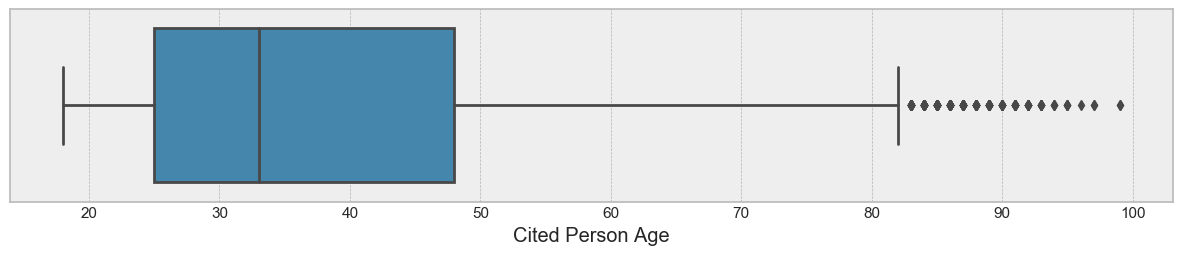

In [592]:
# box plot showing the age distribution of people who receive a citation
plt.figure(figsize=(15,2.5))
sns.boxplot(x=citations.cited_person_age)
plt.xlabel('Cited Person Age')

A boxplot shows that the mean age is in the 30s with a number of outliers in the 80s and 90s age range.

Text(0.5, 0, 'Cited Person Age')

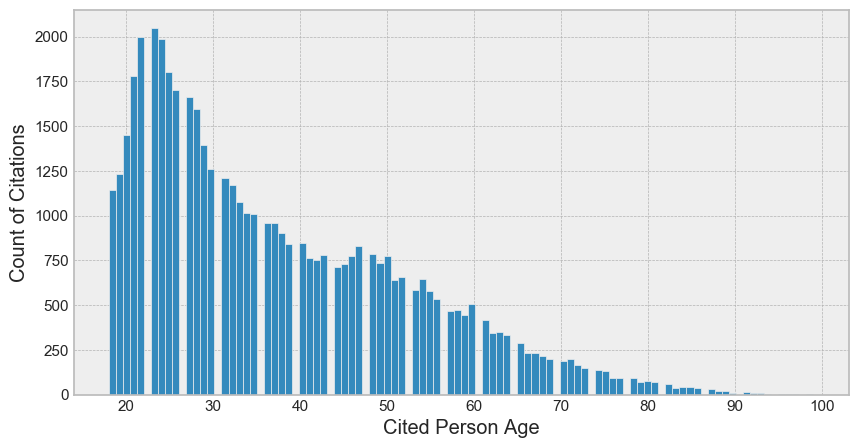

In [593]:
# examine a histogram of the ages of people who received citations
plt.figure(figsize=(10,5))
citations.cited_person_age.hist(bins=100)
plt.ylabel('Count of Citations')
plt.xlabel('Cited Person Age')

The histogram distribution by ages show that younger people receive the largest share of citations.  Interestingly, there is a slight peak in citations within the late 40s age group.

In [594]:
citations.charge_description.value_counts().shape

(395,)

The dataset has 395 unique citations.

In [595]:
citations.charge_description.value_counts()[0:20]

Speed Greater Than R&P or Posted                 11725
Expired/No Arizona Registration                   3972
Suspended/Revoked D.L.                            3001
DUI-Impaired to Slightest Degree                  2272
Failure to Control Speed to Avoid A Collision     2269
No Proof of Insurance                             2244
Drug Paraphernalia-Possess/Use                    2174
Fail to Obey Traffic Control Device               1622
Fail to Stop at Stop Sign                         1348
Fail to Stop For Red Signal                       1310
Exceed Limit By More Than 20mph                   1053
Exceed 15mph In School Crossing                    846
Urinate/Defecate In Public                         778
Void Charge                                        732
Shoplifting-Removal of Goods                       559
Fail to Yield Turning Left at Intersection         553
Display M.I. Suspended Plate                       533
Unsafe Lane Change                                 513
Expired Ou

Since I will be computing averages age for my analysis I want to make sure the citations I am analyzing have a reasonable number.  As a result I will focus my analysis on only the top 20 citations.

In [596]:
round(citations.charge_description.value_counts()[0:20].shape[0]/citations.charge_description.value_counts().shape[0], 3)

0.051

The top 20 citations I have selected make up just over 5% of the total unique citations in the dataset.

In [597]:
round(citations.charge_description.value_counts()[0:20].sum() / citations.charge_description.count(), 3)

0.788

By count of citations in the dataset, the 20 citations I have selected make up 79% of the total citations.

In [598]:
# subset full citation dataset with only the top 20 citations by count
top20_citations = citations[citations.charge_description.isin(citations.charge_description.value_counts()[0:20].index)]

In [599]:
top20_citations.head()

,arizona_statute_code,beat,charge_description,citation_#,citation_date,citation_time,citation_type_code,citation_type_description,cited_person,cited_person_age,...,officer_badge_#,state,street,street_number,zip,zone,tcmainid,month,day_of_week,hour_of_day
1,13-3415A,3.0,Drug Paraphernalia-Possess/Use,2065378,2018-06-23,48,CR,Criminal,"Mysliwiec, Michael",35.0,...,1489,AZ,N 70th St / E McDowell Rd,xxx,NaN,405,621787,6,5,0
3,28-3473A,6.0,Suspended/Revoked D.L.,2058884,2018-06-23,40,CT,Criminal Traffic,"Harrison, Stevia",31.0,...,1466,AZ,E Indian School Rd,7xxx,NaN,906,621794,6,5,0
5,13-3415A,10.0,Drug Paraphernalia-Possess/Use,2063172,2018-06-23,928,CR,Criminal,"Mc Cuan, Michael",51.0,...,1214,AZ,N Hayden Rd,7xxx,NaN,2504,621797,6,5,9
7,28-3473A,12.0,Suspended/Revoked D.L.,1939725,2018-06-23,849,CT,Criminal Traffic,"Montano, Mark",32.0,...,1281,AZ,N 68th Pl / E Cactus Rd,xxx,85254,3104,621801,6,5,8
8,28-1381A1,18.0,DUI-Impaired to Slightest Degree,2065679,2018-06-23,1023,CT,Criminal Traffic,"White, Candice",45.0,...,1452,AZ,L101 / N Pima Rd,xxx,NaN,3802,621804,6,5,10


Text(0.5, 0, 'Month of Year')

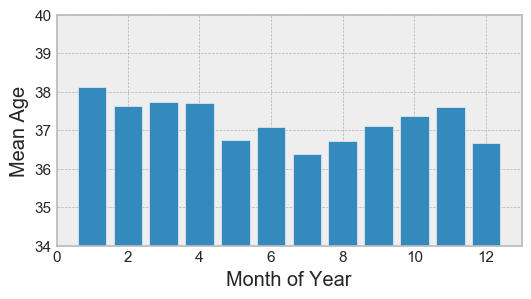

In [600]:
plt.figure(figsize=(6,3))
plt.bar(top20_citations.groupby(top20_citations.month)['cited_person_age'].mean().reset_index().iloc[:,0],
       top20_citations.groupby(top20_citations.month)['cited_person_age'].mean().reset_index().iloc[:,1])

plt.ylim(34, 40)
plt.ylabel('Mean Age')
plt.xlabel('Month of Year')

Looking at the bar chart, we can see that the hotter months of the year are associated with a decline in the mean age of people receiving citations.  However, there is also a sharp decline in December, which does not fit with the hypothesis.

## MONTH OF THE YEAR AND MEAN AGE ANALYSIS

In [601]:
# mean age for top 20 citations at each month of the year
top20_citations.groupby(
    [top20_citations.month, top20_citations.charge_description]) \
    ['cited_person_age'].mean().unstack().head()

charge_description,DUI-Impaired to Slightest Degree,Disorderly Conduct-Disruptive Behavior,Display M.I. Suspended Plate,Drug Paraphernalia-Possess/Use,Exceed 15mph In School Crossing,Exceed Limit By More Than 20mph,Expired Out-Of-State Registration,Expired/No Arizona Registration,Fail to Obey Traffic Control Device,Fail to Stop For Red Signal,Fail to Stop at Stop Sign,Fail to Yield Turning Left at Intersection,Failure to Control Speed to Avoid A Collision,No Proof of Insurance,Shoplifting-Removal of Goods,Speed Greater Than R&P or Posted,Suspended/Revoked D.L.,Unsafe Lane Change,Urinate/Defecate In Public,Void Charge
month,,,,,,,,,,,,,,,,,,,,
1,35.707447,35.916667,32.325581,29.347826,43.548077,34.203704,34.823529,36.895442,41.344828,40.018692,44.776471,43.000000,43.662551,37.637255,33.230769,38.721065,34.561947,48.583333,27.833333,37.492754
2,35.487013,30.977273,35.777778,29.193717,42.103448,33.467532,34.069767,38.296820,42.927273,38.820225,41.741573,54.380952,40.538835,37.375000,33.062500,38.590012,34.679426,49.617021,29.446429,37.015625
3,35.436893,35.617647,35.021739,29.727749,41.526316,32.125000,34.357143,38.337386,42.224806,43.166667,39.915094,46.811321,42.476415,37.753623,35.607843,38.608216,33.781132,44.800000,28.512500,36.591549
4,35.052632,30.815789,33.378378,30.864865,41.955224,34.045455,36.939394,37.294985,41.181102,42.664000,36.963415,46.155172,40.157609,38.403315,34.040000,39.082019,34.954545,45.333333,28.876923,39.979167
5,33.157407,33.791667,36.808511,29.716578,41.966667,32.666667,34.558824,36.545732,40.831933,40.930435,40.579439,40.238095,39.619792,35.820755,33.000000,38.251009,34.325000,43.545455,27.682927,35.958333


In [602]:
# top 5 citations with the highest variability throughout the year
top20_citations.groupby([top20_citations.charge_description, top20_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.var()).sort_values(ascending=False).head(5)

charge_description
Fail to Yield Turning Left at Intersection    20.204360
Fail to Stop For Red Signal                    6.901291
Disorderly Conduct-Disruptive Behavior         5.556823
Unsafe Lane Change                             5.542446
Display M.I. Suspended Plate                   5.237240
Name: cited_person_age, dtype: float64

In [603]:
# subset full citation dataset with only the top 5 highly variable citations by age
top5_variance = citations[citations.charge_description.isin(
    top20_citations.groupby([top20_citations.charge_description, top20_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.var()).sort_values(ascending=False).head(5).index)]

In [604]:
# organize top 5 highly variable citations to be able to graph
top5_variance.groupby([top5_variance.month, top5_variance.charge_description])['cited_person_age'].mean().reset_index().head()

,month,charge_description,cited_person_age
0,1,Disorderly Conduct-Disruptive Behavior,35.916667
1,1,Display M.I. Suspended Plate,32.325581
2,1,Fail to Stop For Red Signal,40.018692
3,1,Fail to Yield Turning Left at Intersection,43.000000
4,1,Unsafe Lane Change,48.583333


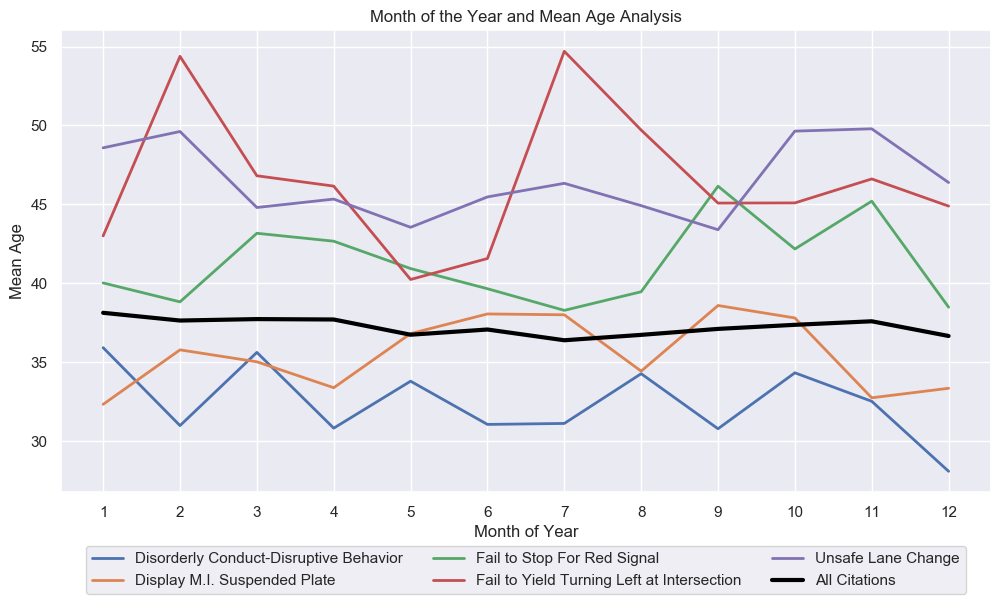

In [605]:
# graph the mean age of citations with highest variance throughout the year
sns.set(rc={'figure.figsize':(12,6)})
sns.set(rc={"lines.linewidth":2})

ax = sns.lineplot(y=top5_variance.groupby([top5_variance.month, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,2],
            x=top5_variance.groupby([top5_variance.month, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,0],
            hue=top5_variance.groupby([top5_variance.month, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,1])

# graph mean age of all citations in bold
x = top20_citations.groupby([top20_citations.month]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,0]

y1 = top20_citations.groupby([top20_citations.month]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,1]

plt.plot(x, y1, color='black',linewidth=3)

plt.ylabel('Mean Age')
plt.xlabel('Month of Year')
plt.title("Month of the Year and Mean Age Analysis")

ax.xaxis.set_major_locator(ticker.MultipleLocator())

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

Three of the above 5 citations graphed across the year indicate that an older person is more likely to receive the citation.  However, the pattern does not seem to show the effects of seasonality.

- Fail to Yield Turing Left at Intersection
- Unsafe Lane Change
- Fail to Stop for Red Signal

## DAY OF THE WEEK AND AGE ANALYSIS

In [606]:
# groupby day of the week and charge description
top5_variance.groupby([top5_variance.day_of_week, top5_variance.charge_description])['cited_person_age'].mean().unstack().head()

charge_description,Disorderly Conduct-Disruptive Behavior,Display M.I. Suspended Plate,Fail to Stop For Red Signal,Fail to Yield Turning Left at Intersection,Unsafe Lane Change
day_of_week,,,,,
0,32.891304,36.356322,42.214724,46.169231,42.640625
1,39.433333,33.783133,42.617347,45.065421,49.794521
2,38.347826,35.860465,40.375000,47.270588,47.282609
3,35.903226,34.602740,42.613065,47.636364,48.255556
4,33.166667,34.945946,38.888350,46.972222,46.778947


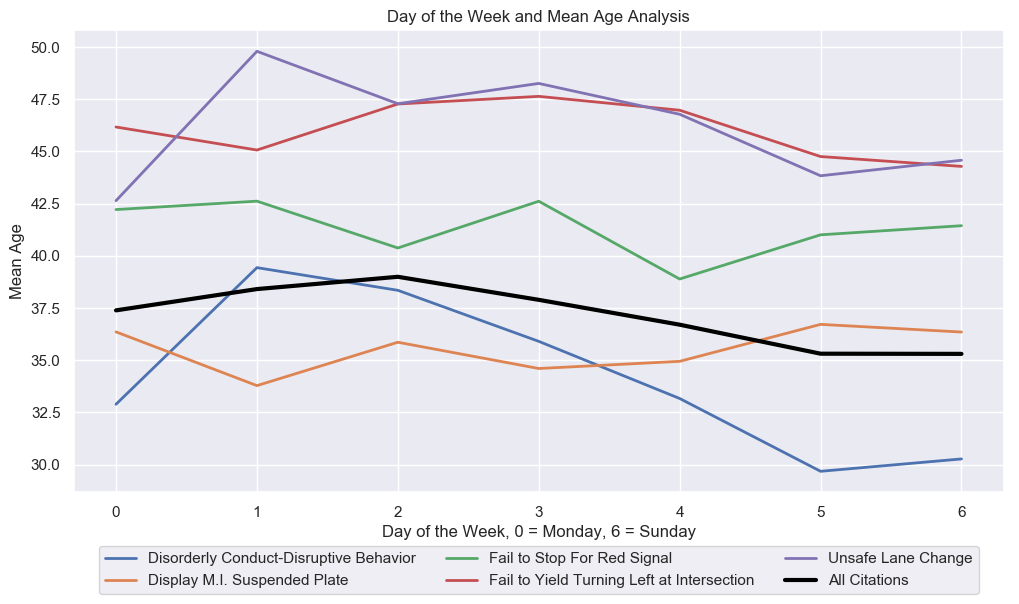

In [607]:
# graph the mean age of citations with highest variance throughout the week
sns.set(rc={'figure.figsize':(12,6)})
sns.set(rc={"lines.linewidth":2})

ax = sns.lineplot(y=top5_variance.groupby([top5_variance.day_of_week, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,2],
            x=top5_variance.groupby([top5_variance.day_of_week, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,0],
            hue=top5_variance.groupby([top5_variance.day_of_week, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,1])

x = top20_citations.groupby(
    [top20_citations.day_of_week]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,0]
y1 = top20_citations.groupby(
    [top20_citations.day_of_week]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,1]

plt.plot(x, y1, color='black',linewidth=3)

plt.ylabel('Mean Age')
plt.xlabel('Day of the Week, 0 = Monday, 6 = Sunday')
plt.title("Day of the Week and Mean Age Analysis")

ax.xaxis.set_major_locator(ticker.MultipleLocator())

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

Three of the above 5 citations graphed across the week show similar patterns.  The larger number of younger people celebrating the weekend causes the mean age to be pulled down during these two days of the week

- Fail to Yield Turing Left at Intersection
- Unsafe Lane Change
- Disorderly Conduct-Disruptive Behavior

## TIME OF DAY AND MEAN AGE ANALYSIS

In [608]:
# groupby hour of day and charge description
top5_variance.groupby([top5_variance.hour_of_day, top5_variance.charge_description])['cited_person_age'].mean().unstack().head()

charge_description,Disorderly Conduct-Disruptive Behavior,Display M.I. Suspended Plate,Fail to Stop For Red Signal,Fail to Yield Turning Left at Intersection,Unsafe Lane Change
hour_of_day,,,,,
0,27.179487,33.131579,33.546667,32.0,28.0
1,27.750000,32.608696,30.552632,51.0,38.0
2,27.277778,34.250000,31.857143,32.0,30.0
3,27.666667,39.333333,37.900000,72.0,NaN
4,28.600000,35.750000,39.300000,61.0,NaN


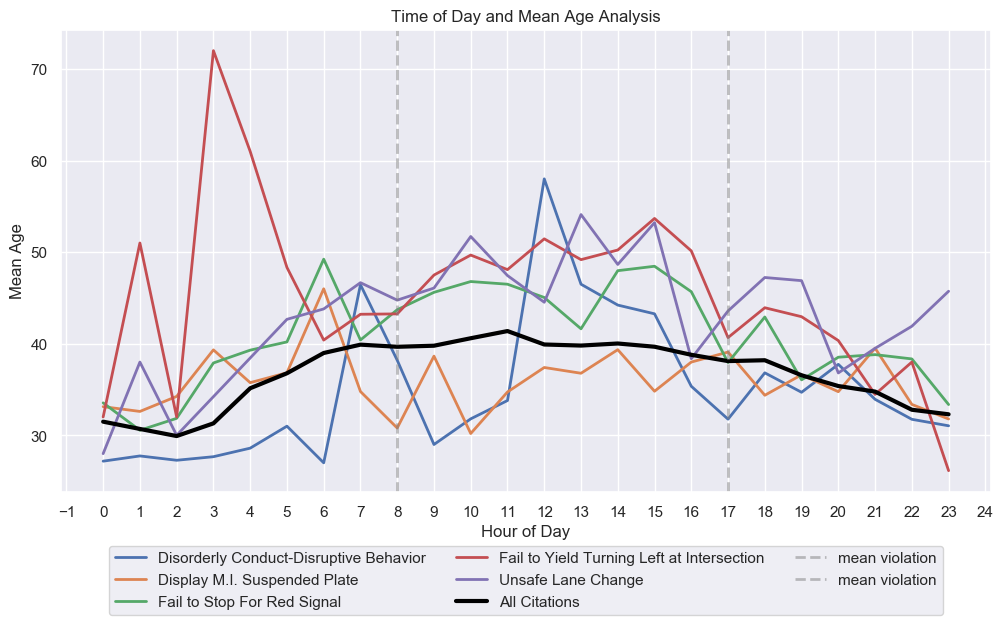

In [609]:
# graph the mean age of citations with highest variance throughout the year
sns.set(rc={'figure.figsize':(12,6)})
sns.set(rc={"lines.linewidth":2})
ax = sns.lineplot(y=top5_variance.groupby([top5_variance.hour_of_day, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,2],
            x=top5_variance.groupby([top5_variance.hour_of_day, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,0],
            hue=top5_variance.groupby([top5_variance.hour_of_day, top5_variance.charge_description])['cited_person_age'].mean().reset_index().iloc[:,1])

x = top20_citations.groupby(
    [top20_citations.hour_of_day]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,0]
y1 = top20_citations.groupby(
    [top20_citations.hour_of_day]) \
    ['cited_person_age'].mean().reset_index().rename(columns={'cited_person_age': 'All Citations'}).iloc[:,1]

plt.plot(x, y1, color='black',linewidth=3)

# plt.axhline(code_violations['_Latitude_'].mean(), color='grey', label='mean violation', linestyle='dashed')
plt.axvline(8, color='grey', label='mean violation', linestyle='dashed', alpha=.5)
plt.axvline(17, color='grey', label='mean violation', linestyle='dashed', alpha=.5)

plt.ylabel('Mean Age')
plt.xlabel('Hour of Day')
plt.title("Time of Day and Mean Age Analysis")

ax.xaxis.set_major_locator(ticker.MultipleLocator())

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

The middle of the day(between 8am and 5pm) show the largest amount of separation from the mean age distribution across the whole day.  This indicates that these citations are more heavily weighted towards older people which likely will not be on the roads at very late and early times of the day.

The above graph shows a lot more noise than the previous graphs.  This is because the data is bucketed in a more granular level(24 buckets) representing each hour of the day.  As a result, there are fewer data points within each hour, causing the mean value to be tugged more dramatically.  This is especially true for the citation "Fail to Yield Turning Left at Intersection" at 3AM - the mean age is over 70.  Likely, one person over 70 was the only person to receive that citation during that hour of the day, causing the mean to be so dramatically high.

## COLD MONTHS vs. HOT MONTHS IN AGGREGATE

### Cold Months Subsetted

In [610]:
# months of the year when I expect the most seasonal visitors(Nov - Feb)
cold_months = [11, 12, 1, 2]
# subset citation data for only the months I expect the most visitors
cold_months_citations = top20_citations[top20_citations.month.isin(cold_months)]

In [611]:
cold_months_citations.groupby([cold_months_citations.charge_description, cold_months_citations.month])['cited_person_age'].mean().unstack().head()

month,1,2,11,12
charge_description,,,,
DUI-Impaired to Slightest Degree,35.707447,35.487013,34.763006,32.492126
Disorderly Conduct-Disruptive Behavior,35.916667,30.977273,32.517241,28.081081
Display M.I. Suspended Plate,32.325581,35.777778,32.740000,33.342857
Drug Paraphernalia-Possess/Use,29.347826,29.193717,29.908602,29.775862
Exceed 15mph In School Crossing,43.548077,42.103448,43.699029,38.615385


In [612]:
# find the mean age for top 20 citations for only the cold months
cold_months_labeled = cold_months_citations.groupby([cold_months_citations.charge_description, cold_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean()).reset_index()
# label cold months
cold_months_labeled.loc[cold_months_labeled.charge_description != '', 'charge_description'] = 'Cold Months'

In [613]:
cold_months_labeled.head()

,charge_description,cited_person_age
0,Cold Months,34.612398
1,Cold Months,31.873065
2,Cold Months,33.546554
3,Cold Months,29.556502
4,Cold Months,41.991485


### Hot Months Subsetted

In [614]:
# months of the year when I expect the least seasonal visitors(June - Sep)
hot_months = [6, 7, 8, 9]
# subset citation data for only the months I expect the most visitors
hot_months_citations = top20_citations[top20_citations.month.isin(hot_months)]

In [615]:
hot_months_citations.groupby([hot_months_citations.charge_description, hot_months_citations.month])['cited_person_age'].mean().unstack().head()

month,6,7,8,9
charge_description,,,,
DUI-Impaired to Slightest Degree,33.622449,33.941176,33.513228,34.325581
Disorderly Conduct-Disruptive Behavior,31.052632,31.114286,34.266667,30.777778
Display M.I. Suspended Plate,38.054054,38.000000,34.428571,38.588235
Drug Paraphernalia-Possess/Use,29.964467,30.016393,32.688742,29.822222
Exceed 15mph In School Crossing,NaN,NaN,38.934066,41.327273


In [616]:
# find the mean age for top 20 citations for only the hot months
hot_months_labeled = hot_months_citations.groupby([hot_months_citations.charge_description, hot_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean()).reset_index()
# label hot months
hot_months_labeled.loc[hot_months_labeled.charge_description != '', 'charge_description'] = 'Hot Months'

In [617]:
hot_months_labeled.head()

,charge_description,cited_person_age
0,Hot Months,33.850609
1,Hot Months,31.802840
2,Hot Months,37.267715
3,Hot Months,30.622956
4,Hot Months,40.130669


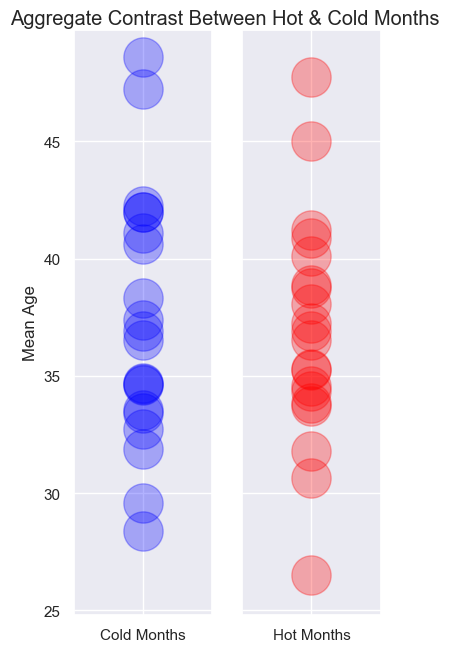

In [618]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(4, 7))

ax[0].scatter(cold_months_citations1.iloc[:,0],
            cold_months_citations1.iloc[:,1],
           alpha=.3,
           s=800,
           color='blue')
ax[0].set_ylabel("Mean Age")

ax[1].scatter(hot_months_citations1.iloc[:,0],
            hot_months_citations1.iloc[:,1],
           alpha=.3,
           s=800,
           color='red',
             label=False)
plt.tight_layout()

st = fig.suptitle("Aggregate Contrast Between Hot & Cold Months")
st.set_y(0.93)
st.set_x(0.55)
fig.subplots_adjust(top=0.90)

Looking at the aggregate contrast between hot and cold months - cold month citations show a clustering around several mean ages, while hot month citations are more evenly distributed.

Text(0, 0.5, 'Citation Description')

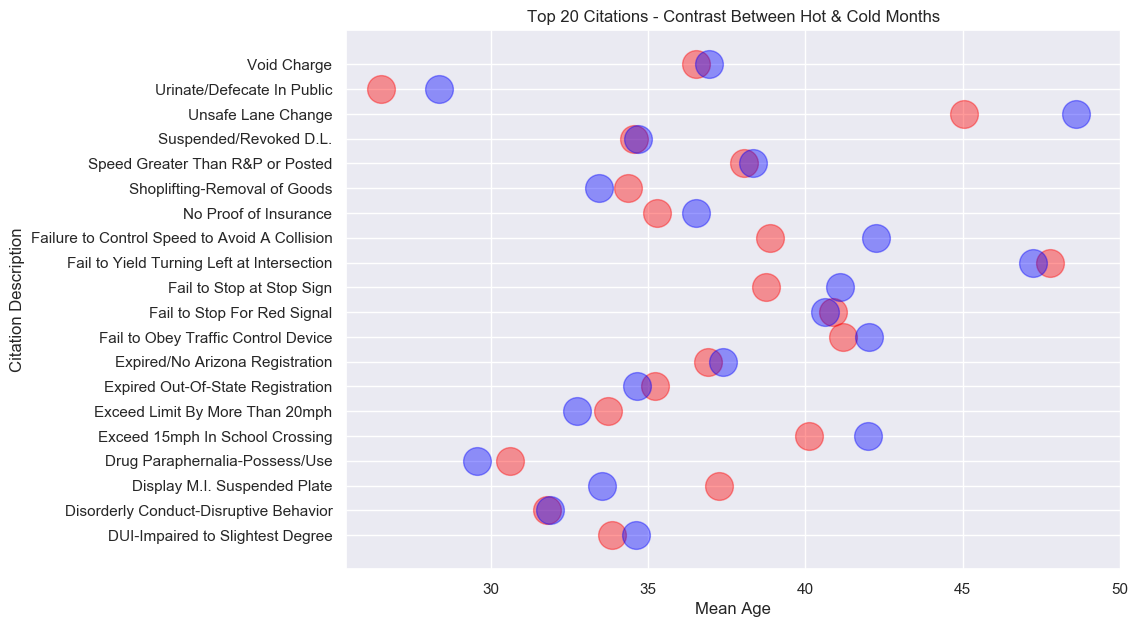

In [619]:
plt.figure(figsize=(10, 7))

plt.scatter(hot_months_citations.groupby([hot_months_citations.charge_description, hot_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean()).values
            
            ,hot_months_citations.groupby([hot_months_citations.charge_description, hot_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean()).index,
           alpha=.4,
           s=400,
           color='red')

plt.scatter(cold_months_citations.groupby([cold_months_citations.charge_description, cold_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean()).values,
            
            cold_months_citations.groupby([cold_months_citations.charge_description, cold_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean()).index,  
           alpha=.4,
           s=400,
           color='blue')

plt.title("Top 20 Citations - Contrast Between Hot & Cold Months")
plt.xlabel("Mean Age")
plt.ylabel("Citation Description")

Many citations show little or no mean age shift between the seasons:
- Disorderly Conduct-Disruptive Behavior
- Suspended/Revoked DL
- Speed Greater Than R&P or Posted

Others citations show a large mean age shift between the seasons:
- Display MI Suspended Plate
- Failure to Control Speed to Avoid a Collision
- Unsafe Lane Change

## PAIRED T-TEST ANALYSIS

**Ho = there is no statistically significant difference between the mean age of people who receive citations during the coldest months of the year and the hottest months of the year**

**Ha = there is a statistically significant difference between the mean age of people who receive citations during the coldest months of the year and the hottest months of the year**

### 1st T-Test: 
Top 20 Citations, Month of Year (Coldest/Hottest Months of Year)

In [620]:
cold_months_citations.groupby([cold_months_citations.charge_description, cold_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean())

charge_description
DUI-Impaired to Slightest Degree                 34.612398
Disorderly Conduct-Disruptive Behavior           31.873065
Display M.I. Suspended Plate                     33.546554
Drug Paraphernalia-Possess/Use                   29.556502
Exceed 15mph In School Crossing                  41.991485
Exceed Limit By More Than 20mph                  32.738803
Expired Out-Of-State Registration                34.656062
Expired/No Arizona Registration                  37.383955
Fail to Obey Traffic Control Device              42.008491
Fail to Stop For Red Signal                      40.630912
Fail to Stop at Stop Sign                        41.090056
Fail to Yield Turning Left at Intersection       47.220238
Failure to Control Speed to Avoid A Collision    42.233483
No Proof of Insurance                            36.531688
Shoplifting-Removal of Goods                     33.429756
Speed Greater Than R&P or Posted                 38.336667
Suspended/Revoked D.L.               

In [621]:
hot_months_citations.groupby([hot_months_citations.charge_description, hot_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean())

charge_description
DUI-Impaired to Slightest Degree                 33.850609
Disorderly Conduct-Disruptive Behavior           31.802840
Display M.I. Suspended Plate                     37.267715
Drug Paraphernalia-Possess/Use                   30.622956
Exceed 15mph In School Crossing                  40.130669
Exceed Limit By More Than 20mph                  33.733824
Expired Out-Of-State Registration                35.231422
Expired/No Arizona Registration                  36.909434
Fail to Obey Traffic Control Device              41.207148
Fail to Stop For Red Signal                      40.886552
Fail to Stop at Stop Sign                        38.763312
Fail to Yield Turning Left at Intersection       47.763721
Failure to Control Speed to Avoid A Collision    38.862284
No Proof of Insurance                            35.273453
Shoplifting-Removal of Goods                     34.363399
Speed Greater Than R&P or Posted                 38.055536
Suspended/Revoked D.L.               

In [622]:
# t-test comparison
ttest_ind(
    cold_months_citations.groupby([cold_months_citations.charge_description, cold_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean()),
      
    hot_months_citations.groupby([hot_months_citations.charge_description, hot_months_citations.month])['cited_person_age'].mean() \
    .groupby(level=0).apply(lambda x: x.mean())
    )

Ttest_indResult(statistic=0.2778308728135038, pvalue=0.7826482650340848)

### 2nd T-Test: 
Top 5 Citations, Day of Week (Coldest/Hottest Months of Year)

In [623]:
top5_variance[top5_variance.month.isin(cold_months)].groupby(['day_of_week'])['cited_person_age'].mean()

day_of_week
0    40.298611
1    42.446328
2    42.176166
3    43.666667
4    41.984375
5    37.587500
6    36.771429
Name: cited_person_age, dtype: float64

In [624]:
top5_variance[top5_variance.month.isin(hot_months)].groupby(['day_of_week'])['cited_person_age'].mean()

day_of_week
0    39.991379
1    41.990991
2    40.869565
3    43.554795
4    40.693252
5    38.180645
6    39.239669
Name: cited_person_age, dtype: float64

In [625]:
ttest_ind(
    top5_variance[top5_variance.month.isin(cold_months)].groupby(['day_of_week'])['cited_person_age'].mean(),
      
    top5_variance[top5_variance.month.isin(hot_months)].groupby(['day_of_week'])['cited_person_age'].mean()
    )

Ttest_indResult(statistic=0.04919250540121592, pvalue=0.9615751767945577)

### 3rd T-Test: Top 5 Citations, Hour of Day (Coldest/Hottest Months of Year)

In [626]:
top5_variance[top5_variance.month.isin(cold_months)].groupby(['hour_of_day'])['cited_person_age'].mean()

hour_of_day
0     31.816667
1     28.288462
2     28.846154
3     25.250000
4     35.571429
5     40.909091
6     45.666667
7     40.277778
8     45.000000
9     48.640000
10    42.903846
11    44.587302
12    44.952381
13    43.687500
14    48.280488
15    45.551282
16    43.119403
17    38.785714
18    42.723684
19    39.481481
20    38.789474
21    37.808511
22    34.820000
23    34.941176
Name: cited_person_age, dtype: float64

In [627]:
top5_variance[top5_variance.month.isin(hot_months)].groupby(['hour_of_day'])['cited_person_age'].mean()

hour_of_day
0     32.266667
1     30.191489
2     32.526316
3     37.600000
4     38.000000
5     41.000000
6     45.307692
7     47.151515
8     41.000000
9     44.794118
10    45.419355
11    46.086957
12    42.304348
13    49.689655
14    43.542373
15    47.822581
16    43.568966
17    40.481481
18    41.265306
19    39.305556
20    35.775000
21    36.227273
22    38.190476
23    30.274194
Name: cited_person_age, dtype: float64

In [628]:
ttest_ind(
    top5_variance[top5_variance.month.isin(cold_months)].groupby(['hour_of_day'])['cited_person_age'].mean(),
      
    top5_variance[top5_variance.month.isin(hot_months)].groupby(['hour_of_day'])['cited_person_age'].mean()
    )

Ttest_indResult(statistic=-0.4607466311049906, pvalue=0.647151357738445)

Since the p-value for all of the T-tests are larger than .05(the general benchmark for statistical significance), I must accept the null hypothesis that **there is no statistically significant difference between the mean age of people who receive citations during the coldest months of the year and the hottest months of the year**.

## CONCLUSION
There are several citations that are more frequently issued to older people in Scottsdale, Arizona.  Specifically:
- Fail to Yield Turning Left at Intersection
- Unsafe Lane Change
- Fail to Stop for Red Signal

However, there is no statistically significant evidence indicating that the mean age of people who receive citations during the cooler months of the year are any older than those who receive citations during the hotter months of the year.

### Further Consideration:
1. If I were to obtain 10 years worth of data, would I see these same trends continue?
1. On the other end of the spectrum from older visitors, is there evidence of specific pockets of younger visitors who might visit the area for events like spring break or baseball spring training?
1. Which citations show the smallest variance in terms of the mean age of the person receiving the citation, and the mean age fluctuation throughout the year?